<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Purpose" data-toc-modified-id="Purpose-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Purpose</a></span></li><li><span><a href="#Input" data-toc-modified-id="Input-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Input</a></span></li><li><span><a href="#Output" data-toc-modified-id="Output-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Output</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Parameters</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Load data</a></span><ul class="toc-item"><li><span><a href="#Cell-meta" data-toc-modified-id="Cell-meta-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Cell meta</a></span></li><li><span><a href="#MCDS" data-toc-modified-id="MCDS-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>MCDS</a></span></li></ul></li><li><span><a href="#Filter-feature" data-toc-modified-id="Filter-feature-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Filter feature</a></span><ul class="toc-item"><li><span><a href="#Remove-chromosome" data-toc-modified-id="Remove-chromosome-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Remove chromosome</a></span></li><li><span><a href="#Remove-blacklist-region" data-toc-modified-id="Remove-blacklist-region-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Remove blacklist region</a></span><ul class="toc-item"><li><span><a href="#Get-feature-bed" data-toc-modified-id="Get-feature-bed-6.2.1"><span class="toc-item-num">6.2.1&nbsp;&nbsp;</span>Get feature bed</a></span></li><li><span><a href="#Get-black-list-bed" data-toc-modified-id="Get-black-list-bed-6.2.2"><span class="toc-item-num">6.2.2&nbsp;&nbsp;</span>Get black list bed</a></span></li></ul></li><li><span><a href="#Remove-by-mean-cov" data-toc-modified-id="Remove-by-mean-cov-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Remove by mean cov</a></span></li></ul></li><li><span><a href="#Add-mC-rate" data-toc-modified-id="Add-mC-rate-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Add mC rate</a></span></li><li><span><a href="#Select-HVF" data-toc-modified-id="Select-HVF-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Select HVF</a></span><ul class="toc-item"><li><span><a href="#mCH-HVF" data-toc-modified-id="mCH-HVF-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>mCH HVF</a></span></li><li><span><a href="#mCG-HVF" data-toc-modified-id="mCG-HVF-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>mCG HVF</a></span></li></ul></li><li><span><a href="#Get-Anndata" data-toc-modified-id="Get-Anndata-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Get Anndata</a></span><ul class="toc-item"><li><span><a href="#Load-HVF" data-toc-modified-id="Load-HVF-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Load HVF</a></span></li><li><span><a href="#CH-adata" data-toc-modified-id="CH-adata-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>CH adata</a></span></li><li><span><a href="#CG-adata" data-toc-modified-id="CG-adata-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>CG adata</a></span></li></ul></li><li><span><a href="#Prepare-Gene" data-toc-modified-id="Prepare-Gene-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Prepare Gene</a></span></li></ul></div>

# Prepare AnnData and Highly Variable Feature Selection

## Purpose
- Calculate methylation rate
- Normalize per cell and clip extreme
- HVF selection
- Prepare HVF adata file
- Prepare gene adata file
- Basically, from N-D to 2-D

## Input
- Cell metadata table, MCDS list

## Output
- mCH HVF adata
- mCG HVF adata
- Gene rate MCDS

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy.api as sc
import seaborn as sns
import xarray as xr
from pybedtools import BedTool
from ALLCools.mcds.MCDS import MCDS
from cemba_data.plot import *

In [3]:
result_dir = pathlib.Path('Adata')
result_dir.mkdir(exist_ok=True)
fig_dir = pathlib.Path('fig/feature_selection')
fig_dir.mkdir(exist_ok=True, parents=True)

## Parameters

In [4]:
# parameters cell
in_memory = False
dask_distribute = True

# selected cell metadata path
cell_meta_path = ''

# blacklist
black_list_path = '/home/hanliu/project/mouse_rostral_brain/misc/mm10-blacklist.v2.bed.gz'

# mcds_path
mcds_path_list = list(pathlib.Path('/home/hanliu/project/mouse_rostral_brain/dataset/').glob('*mcds'))

clustering_feature = 'chrom100k'  # usually 100kb chromosome bins or genes

# remove bad features
black_list_region = None
exclude_chromosome = ['chrY', 'chrM']

# preprocess parameters
min_feature_cov, max_feature_cov = 500, 3000

ch_hvf_top = 3000
min_ch_hvf_mean = 0.5
max_ch_hvf_mean = 2.5

cg_hvf_top = 3000
min_cg_hvf_mean = 0.5
max_cg_hvf_mean = 1.2

In [5]:
if dask_distribute:
    from dask.distributed import Client
    client = Client(dashboard_address=':5555')

## Load data
### Cell meta

In [6]:
cell_meta = pd.read_msgpack('CellMetadata.AfterQC.msg')
cell_meta.shape[0]

109670

### MCDS

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    mcds = MCDS.open(mcds_path_list,
                     use_cells=cell_meta[cell_meta['PassFilter']].index,
                     chunks={'cell': 1000})
if in_memory:
    mcds.load()

In [8]:
mcds

<xarray.MCDS>
Dimensions:              (cell: 104340, chrom100k: 27269, count_type: 2, gene: 55487, mc_type: 2)
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
  * gene                 (gene) object 'ENSMUSG00000102693.1' ... 'ENSMUSG00000064372.1'
  * count_type           (count_type) object 'mc' 'cov'
    strand_type          <U4 'both'
    gene_chrom           (gene) object dask.array<shape=(55487,), chunksize=(55487,)>
    gene_start           (gene) int64 dask.array<shape=(55487,), chunksize=(55487,)>
    gene_end             (gene) int64 dask.array<shape=(55487,), chunksize=(55487,)>
  * cell                 (cell) object '1A_M_0' '1A_M_1' ... '10F_M_998'
  * chrom100k            (chrom100k) int64 0 1 2 3 4 ... 27265 27266 27267 27268
    chrom100k_chrom      (chrom100k) object dask.array<shape=(27269,), chunksize=(27269,)>
    chrom100k_bin_start  (chrom100k) int64 dask.array<shape=(27269,), chunksize=(27269,)>
    chrom100k_bin_end    (chrom100k) int64 dask.a

## Filter feature

### Remove chromosome

In [9]:
mcds = mcds.sel(chrom100k=~mcds.coords[f'{clustering_feature}_chrom'].isin(
    exclude_chromosome))

### Remove blacklist region

#### Get feature bed

In [10]:
feature_bed_df = pd.DataFrame([
    mcds.coords[f'{clustering_feature}_chrom'].to_pandas(),
    mcds.coords[f'{clustering_feature}_bin_start'].to_pandas(),
    mcds.coords[f'{clustering_feature}_bin_end'].to_pandas()
],
                              index=['chrom', 'start', 'end'],
                              columns=mcds.get_index(clustering_feature)).T
feature_bed = BedTool.from_dataframe(feature_bed_df)

#### Get black list bed

In [11]:
black_list_bed = BedTool(black_list_path)
black_feature = feature_bed.intersect(black_list_bed, f=0.2, wa=True)
black_feature_index = black_feature.to_dataframe().set_index(
    ['chrom', 'start', 'end']).index
black_feature_id = pd.Index(feature_bed_df.reset_index()\
                       .set_index(['chrom', 'start', 'end'])\
                       .loc[black_feature_index][clustering_feature])

In [12]:
mcds = mcds.sel(chrom100k=~mcds.get_index(clustering_feature).isin(black_feature_id))

### Remove by mean cov

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


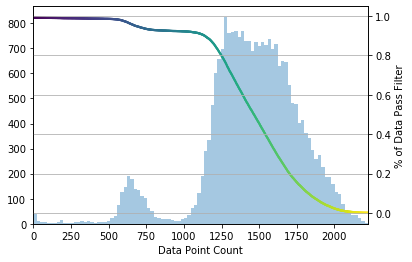

In [13]:
# only calculate CHN
fig, axes = cutoff_vs_cell_remain(mcds[f'{clustering_feature}_da']\
                                  .sel(count_type='cov', mc_type='CHN')\
                                  .mean(axis=0)\
                                  .load())
fig.savefig(fig_dir / f'region_mean_CHN_cov.pdf')

In [14]:
before = mcds.coords[clustering_feature].size
mcds = mcds.filter_region_cov(dim=clustering_feature,
                              da=f'{clustering_feature}_da',
                              mc_type='CHN',
                              min_cov=min_feature_cov,
                              max_cov=max_feature_cov)
after = mcds.coords[clustering_feature].size
print(
    f'Filter {clustering_feature} by [{min_feature_cov}, {max_feature_cov}], '
    f'filter rate {(after / before):.2f}. {after} features remained.')

Filter chrom100k by [500, 3000], filter rate 0.99. 24030 features remained.


## Add mC rate

In [15]:
mcds.add_mc_rate(dim=clustering_feature, da=f'{clustering_feature}_da')

## Select HVF

### mCH HVF

In [16]:
ch_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CHN',
    min_disp=None,
    max_disp=None,
    min_mean=min_ch_hvf_mean,
    max_mean=max_ch_hvf_mean,
    n_top_feature=ch_hvf_top,
    bin_min_features=5,
    mean_binsize=0.05,
    cov_binsize=100)

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Total Feature Number:     24030
Highly Variable Feature:  2999 (12.5%)


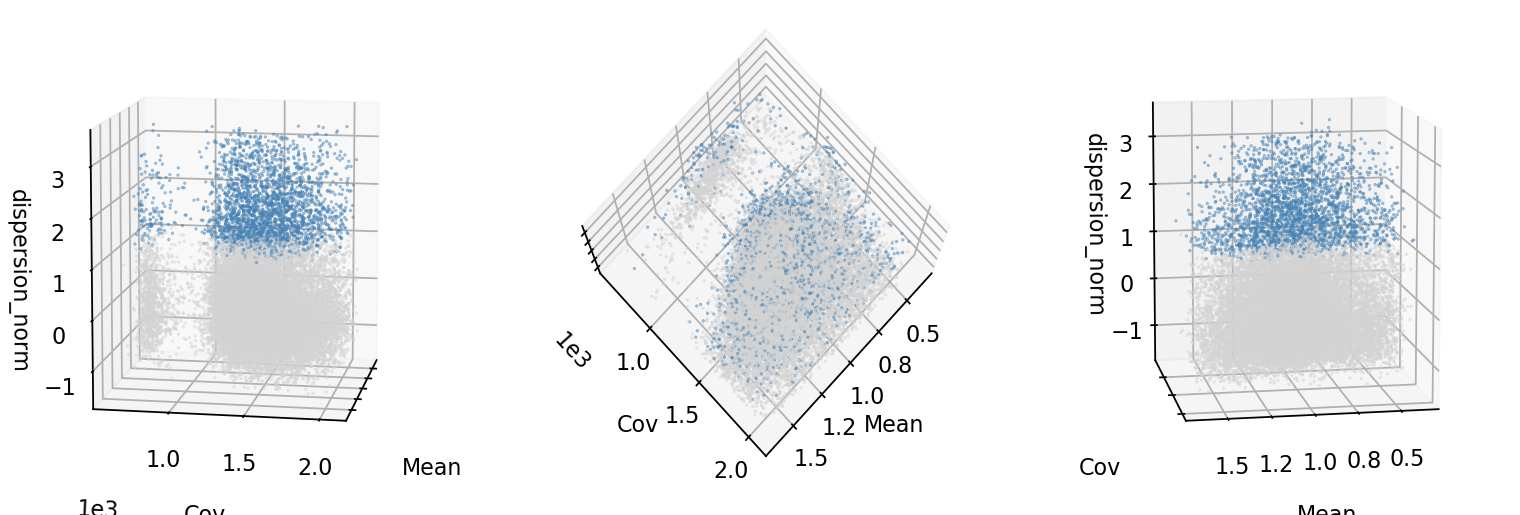

In [17]:
selection = ch_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(ch_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'ch_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

### mCG HVF

In [18]:
cg_hvf_df = mcds.highly_variable_methylation_feature(
    var_dim=clustering_feature,
    mc_type='CGN',
    min_disp=None,
    max_disp=None,
    min_mean=min_cg_hvf_mean,
    max_mean=max_cg_hvf_mean,
    n_top_feature=cg_hvf_top,
    bin_min_features=5,
    mean_binsize=0.01,
    cov_binsize=10)

distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

Total Feature Number:     24030
Highly Variable Feature:  3000 (12.5%)


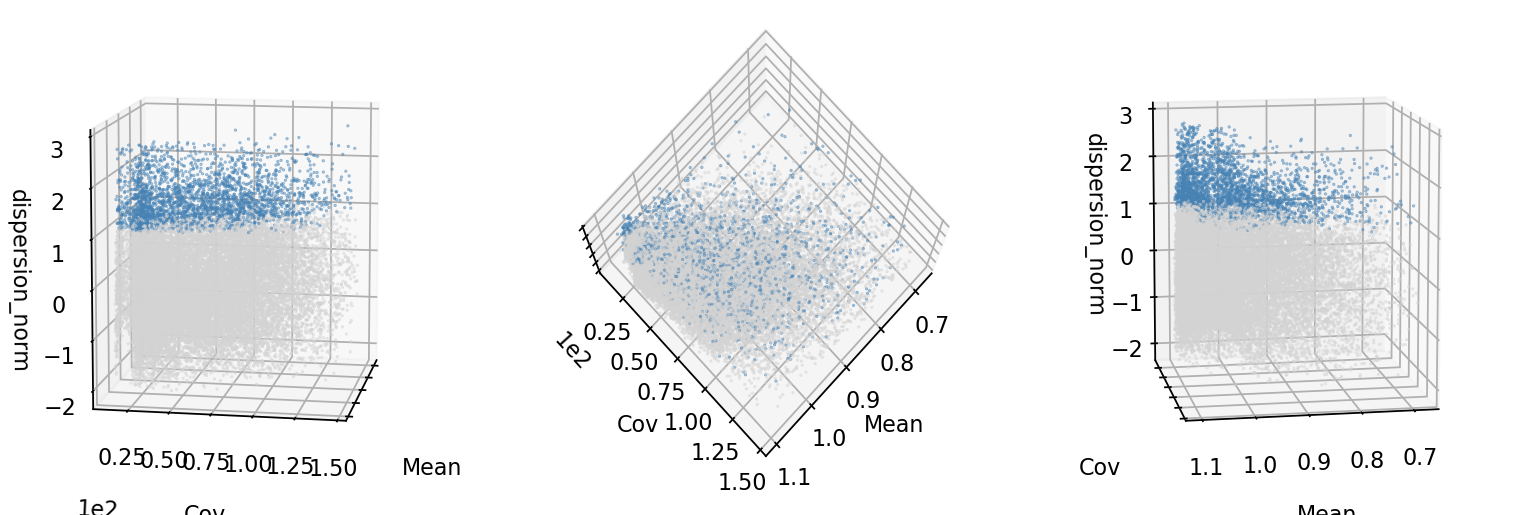

In [19]:
selection = cg_hvf_df['gene_subset']
print(f'Total Feature Number:     {selection.size}')
print(
    f'Highly Variable Feature:  {selection.sum()} ({(selection.sum() / selection.size * 100):.1f}%)'
)

fig, axes = plot_dispersion(cg_hvf_df,
                            hue='gene_subset',
                            zlab='dispersion_norm',
                            data_quantile=(0.01, 0.99),
                            save_animate_path=None,
                            fig_kws=None)
fig.savefig(fig_dir / f'cg_highly_variable_feature.{clustering_feature}.png',
            bbox_inches='tight')

## Get Anndata

### Load HVF

In [20]:
selected_ch_feature = ch_hvf_df[ch_hvf_df['gene_subset']].index
selected_cg_feature = cg_hvf_df[cg_hvf_df['gene_subset']].index

mcds = mcds.sel(chrom100k=(selected_ch_feature | selected_cg_feature))
mcds['chrom100k_da_rate'].load()

distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.DataArray 'chrom100k_da_rate' (cell: 104340, chrom100k: 5494, mc_type: 2)>
array([[[1.141773, 0.589887],
        [0.954864, 0.605759],
        ...,
        [1.048349, 0.524748],
        [0.711195, 0.765691]],

       [[1.001525, 0.379509],
        [0.686331, 0.379562],
        ...,
        [0.932945, 0.349636],
        [0.569981, 0.452881]],

       ...,

       [[1.150777, 1.006422],
        [1.06354 , 0.682217],
        ...,
        [1.088433, 0.783658],
        [1.024026, 1.177798]],

       [[1.099635, 1.036522],
        [0.986077, 0.976074],
        ...,
        [1.137904, 1.166152],
        [0.808769, 1.197344]]])
Coordinates:
  * mc_type              (mc_type) object 'CGN' 'CHN'
    strand_type          <U4 'both'
  * cell                 (cell) object '1A_M_0' '1A_M_1' ... '10F_M_998'
  * chrom100k            (chrom100k) int64 32 33 34 35 ... 26318 26319 26332
    chrom100k_chrom      (chrom100k) object 'chr1' 'chr1' ... 'chrX' 'chrX'
    chrom100k_bin_start  (chrom100k

### CH adata

In [21]:
ch_adata = mcds.sel(chrom100k=selected_ch_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CHN')
ch_adata.write_h5ad(result_dir / 'mch_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [22]:
ch_adata

AnnData object with n_obs × n_vars = 104340 × 2999 

### CG adata

In [23]:
cg_adata = mcds.sel(chrom100k=selected_cg_feature).to_ann(
    f'{clustering_feature}_da_rate', var_dim=clustering_feature, mc_type='CGN')
cg_adata.write_h5ad(result_dir / 'mcg_adata.norm_per_cell.hvf.h5ad')

Transforming to str index.


In [24]:
cg_adata

AnnData object with n_obs × n_vars = 104340 × 3000 

## Prepare Gene

In [9]:
if clustering_feature != 'gene':
    mcds.add_gene_rate(in_memory=False,
                       output_prefix=str(result_dir / 'SelectedCell'),
                       cell_chunks=10000)

distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
distributed.nanny - WARNING - Worker exceeded 95% memory budget. Restarting
distributed.nanny - WARNING - Restarting worker
